In [1]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn for better confusion matrix plots

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score # Added metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-05-24 04:22:41.700014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748060562.129913      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748060562.265584      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ----- 0. GLOBAL CONSTANTS AND KEYPOINT DEFINITIONS -----

# !!! --- ACTION REQUIRED: REPLACE WITH YOUR ACTUAL 17 KEYPOINT NAMES --- !!!
# รายชื่อ keypoint ทั้ง 17 ชื่อจากไฟล์ CSV
# ลำดับใน list นี้ไม่สำคัญ เพราะจะถูก sort เพื่อสร้าง KEYPOINT_DICT
KEYPOINT_NAMES = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
] 

# Sort ชื่อ keypoint ตามตัวอักษร (นี่คือลำดับที่ pivot_table ใน generate_fall_sequences.py จะใช้)
SORTED_KEYPOINT_NAMES = sorted(KEYPOINT_NAMES)

# สร้าง KEYPOINT_DICT ที่ถูกต้องตามลำดับการ sort นี้
KEYPOINT_DICT = {name: i for i, name in enumerate(SORTED_KEYPOINT_NAMES)}

# ตั้งค่า NUM_KEYPOINTS จาก KEYPOINT_DICT ที่สร้างขึ้น
NUM_KEYPOINTS = len(KEYPOINT_DICT)

# พิมพ์ออกมาตรวจสอบ
print("--- Initializing Keypoint Definitions ---")
print(f"KEYPOINT_NAMES (before sort): {KEYPOINT_NAMES}")
print(f"SORTED_KEYPOINT_NAMES (used for ordering): {SORTED_KEYPOINT_NAMES}")
print(f"Generated KEYPOINT_DICT: {KEYPOINT_DICT}")
print(f"NUM_KEYPOINTS: {NUM_KEYPOINTS}")

if NUM_KEYPOINTS != 17:
    print(f"WARNING: NUM_KEYPOINTS is {NUM_KEYPOINTS}, but typically expected to be 17 for your case.")
    print("Please double-check the 'KEYPOINT_NAMES' list.")
print("----------------------------------------")

--- Initializing Keypoint Definitions ---
KEYPOINT_NAMES (before sort): ['Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear', 'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow', 'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip', 'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle']
SORTED_KEYPOINT_NAMES (used for ordering): ['Left Ankle', 'Left Ear', 'Left Elbow', 'Left Eye', 'Left Hip', 'Left Knee', 'Left Shoulder', 'Left Wrist', 'Nose', 'Right Ankle', 'Right Ear', 'Right Elbow', 'Right Eye', 'Right Hip', 'Right Knee', 'Right Shoulder', 'Right Wrist']
Generated KEYPOINT_DICT: {'Left Ankle': 0, 'Left Ear': 1, 'Left Elbow': 2, 'Left Eye': 3, 'Left Hip': 4, 'Left Knee': 5, 'Left Shoulder': 6, 'Left Wrist': 7, 'Nose': 8, 'Right Ankle': 9, 'Right Ear': 10, 'Right Elbow': 11, 'Right Eye': 12, 'Right Hip': 13, 'Right Knee': 14, 'Right Shoulder': 15, 'Right Wrist': 16}
NUM_KEYPOINTS: 17
----------------------------------------


In [3]:
# ----- 1. HELPER FUNCTION FOR KEYPOINT INDICES -----
def get_kpt_indices(keypoint_name):
    if keypoint_name not in KEYPOINT_DICT:
        available_keys = list(KEYPOINT_DICT.keys())
        similar_keys = [k for k in available_keys if keypoint_name.lower() in k.lower() or k.lower() in keypoint_name.lower()]
        error_msg = f"Keypoint name '{keypoint_name}' not found in KEYPOINT_DICT. "
        error_msg += f"Available keys are: {available_keys}. "
        if similar_keys: error_msg += f"Did you mean one of these: {similar_keys}? "
        raise ValueError(error_msg)
    kp_idx = KEYPOINT_DICT[keypoint_name]
    return kp_idx * 3, kp_idx * 3 + 1, kp_idx * 3 + 2

In [4]:
# ----- 2. SKELETON NORMALIZATION FUNCTION -----
def normalize_skeleton(sequence_data, min_confidence=0.3):
    normalized_sequence = np.copy(sequence_data)
    ref_kp_names = {
        'ls': 'Left Shoulder', 'rs': 'Right Shoulder',
        'lh': 'Left Hip', 'rh': 'Right Hip'
    }
    for ref_kp_key, ref_kp_name_val in ref_kp_names.items():
        if ref_kp_name_val not in KEYPOINT_DICT:
            print(f"FATAL WARNING in normalize_skeleton: Reference keypoint '{ref_kp_name_val}' (for {ref_kp_key}) "
                  f"is not defined in your KEYPOINT_NAMES / KEYPOINT_DICT. Normalization will likely fail.")

    for t in range(sequence_data.shape[0]):
        frame_data = sequence_data[t, :]
        current_frame_normalized = np.copy(frame_data)
        try:
            ls_x_idx, ls_y_idx, ls_c_idx = get_kpt_indices(ref_kp_names['ls'])
            rs_x_idx, rs_y_idx, rs_c_idx = get_kpt_indices(ref_kp_names['rs'])
            lh_x_idx, lh_y_idx, lh_c_idx = get_kpt_indices(ref_kp_names['lh'])
            rh_x_idx, rh_y_idx, rh_c_idx = get_kpt_indices(ref_kp_names['rh'])
        except ValueError:
            normalized_sequence[t, :] = frame_data; continue

        ls_x, ls_y, ls_c = frame_data[ls_x_idx], frame_data[ls_y_idx], frame_data[ls_c_idx]
        rs_x, rs_y, rs_c = frame_data[rs_x_idx], frame_data[rs_y_idx], frame_data[rs_c_idx]
        lh_x, lh_y, lh_c = frame_data[lh_x_idx], frame_data[lh_y_idx], frame_data[lh_c_idx]
        rh_x, rh_y, rh_c = frame_data[rh_x_idx], frame_data[rh_y_idx], frame_data[rh_c_idx]

        mid_shoulder_x, mid_shoulder_y = np.nan, np.nan
        valid_ls, valid_rs = ls_c > min_confidence, rs_c > min_confidence
        if valid_ls and valid_rs: mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        elif valid_ls: mid_shoulder_x, mid_shoulder_y = ls_x, ls_y
        elif valid_rs: mid_shoulder_x, mid_shoulder_y = rs_x, rs_y

        mid_hip_x, mid_hip_y = np.nan, np.nan
        valid_lh, valid_rh = lh_c > min_confidence, rh_c > min_confidence
        if valid_lh and valid_rh: mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
        elif valid_lh: mid_hip_x, mid_hip_y = lh_x, lh_y
        elif valid_rh: mid_hip_x, mid_hip_y = rh_x, rh_y

        if np.isnan(mid_hip_x) or np.isnan(mid_hip_y):
            normalized_sequence[t, :] = frame_data; continue

        reference_height = np.nan
        if not np.isnan(mid_shoulder_y) and not np.isnan(mid_hip_y):
            reference_height = np.abs(mid_shoulder_y - mid_hip_y)

        perform_scaling = not (np.isnan(reference_height) or reference_height < 1e-5)

        for kp_i in range(NUM_KEYPOINTS):
            x_i_col, y_i_col = kp_i * 3, kp_i * 3 + 1
            current_frame_normalized[x_i_col] -= mid_hip_x
            current_frame_normalized[y_i_col] -= mid_hip_y
            if perform_scaling:
                current_frame_normalized[x_i_col] /= reference_height
                current_frame_normalized[y_i_col] /= reference_height
        normalized_sequence[t, :] = current_frame_normalized
    return normalized_sequence

In [5]:
# ----- 3. DATA LOADING FUNCTION (ปรับปรุงให้คืนค่า npy_filepaths) -----
def load_dataset(data_path, expected_shape_template=(30, None), normalize=True, min_confidence_norm=0.3):
    if NUM_KEYPOINTS is None or NUM_KEYPOINTS == 0: # สมมติว่า NUM_KEYPOINTS ถูก define ไว้แล้ว
        raise ValueError("NUM_KEYPOINTS is not set or is zero. Cannot determine expected shape.")
    expected_shape = (expected_shape_template[0], NUM_KEYPOINTS * 3)
    
    X, y = [], []
    npy_filepaths = [] # <--- เพิ่ม list นี้

    print(f"Loading data from: {data_path}, expecting shape {expected_shape} for .npy files.")
    for label_name, label_val in [('no_fall', 0), ('fall', 1)]:
        folder = os.path.join(data_path, label_name)
        if not os.path.isdir(folder):
            print(f"Warning: Subfolder not found for label '{label_name}': {folder}")
            continue
        
        files_in_folder = glob(os.path.join(folder, "*.npy"))
        print(f"Found {len(files_in_folder)} .npy files in {folder}")
        
        loaded_count_for_label = 0
        for file_path_str in files_in_folder: # file_path_str คือ path เต็มของ .npy
            file_path_obj = Path(file_path_str) # แปลงเป็น Path object ถ้าต้องการ
            try:
                arr = np.load(file_path_str)
            except Exception as e:
                print(f"Warning: Could not load file {file_path_str}: {e}")
                continue

            if arr.shape == expected_shape:
                if normalize:
                    arr_normalized = normalize_skeleton(arr, min_confidence=min_confidence_norm) # สมมติว่า normalize_skeleton มีอยู่
                    if np.isnan(arr_normalized).any():
                        arr_normalized = np.nan_to_num(arr_normalized, nan=0.0, posinf=0.0, neginf=0.0)
                    X.append(arr_normalized)
                else:
                    X.append(arr)
                y.append(label_val)
                npy_filepaths.append(file_path_str) # <--- เก็บ path เต็มของไฟล์ .npy
                loaded_count_for_label += 1
            else:
                print(f"Warning: Skipping file {file_path_str} due to incorrect shape: {arr.shape}. Expected: {expected_shape}")
        print(f"Successfully loaded {loaded_count_for_label} samples for label '{label_name}'.")

    if not X:
        print(f"Critical Warning: No data was loaded from {data_path}. Check paths, subfolder names, .npy files, and NUM_KEYPOINTS.")
        return np.array([]), np.array([]), [] # <--- คืนค่า list ว่างสำหรับ filepaths ด้วย
        
    return np.array(X), np.array(y), npy_filepaths # <--- คืนค่า npy_filepaths

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional # เพิ่ม Bidirectional
from tensorflow.keras.optimizers import Adam

# ----- 4. Bi-LSTM MODEL DEFINITION (ปรับปรุงเป็น Bi-LSTM) -----
def create_bilstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.5):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, return_sequences=False), input_shape=input_shape),
        Dropout(dropout_rate), # Dropout หลัง Bi-LSTM layer
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate / 2), # Dropout หลัง Dense layer
        Dense(1, activation='sigmoid') # Output layer สำหรับ binary classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
import numpy as np
import os # ถ้า load_dataset หรือส่วนอื่นใช้
from pathlib import Path # ถ้า load_dataset หรือส่วนอื่นใช้
from glob import glob # ถ้า load_dataset หรือส่วนอื่นใช้


# Paths 
base_train = '/kaggle/input/fall-dataset6/train'
base_val   = '/kaggle/input/fall-dataset6/val'
base_test  = '/kaggle/input/fall-dataset6/test'

# ----- Parameters -----
TIMESTEPS = 30
EXPECTED_SHAPE_TEMPLATE = (TIMESTEPS, None) # NUM_KEYPOINTS will be used in load_dataset
MIN_CONF_NORM = 0.2

# Load Datasets
print("\n--- Loading Training Data ---")
X_train_orig, y_train_orig, train_npy_filepaths = load_dataset(
    base_train, 
    expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=True, 
    min_confidence_norm=MIN_CONF_NORM
)
print("\n--- Loading Validation Data ---")
X_val_orig, y_val_orig, val_npy_filepaths = load_dataset(
    base_val, 
    expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=True, 
    min_confidence_norm=MIN_CONF_NORM
)
print("\n--- Loading Test Data ---")
X_test_orig, y_test_orig, test_npy_filepaths = load_dataset(
    base_test, 
    expected_shape_template=EXPECTED_SHAPE_TEMPLATE, 
    normalize=True, 
    min_confidence_norm=MIN_CONF_NORM
)

# ตรวจสอบว่า Training data โหลดสำเร็จหรือไม่
if X_train_orig.size == 0:
    print("FATAL ERROR: Training data is empty. Further execution might fail.")
    # คุณอาจจะต้องการหยุดการทำงานของ Notebook ที่นี่ถ้า training data จำเป็น
    # raise SystemExit("Exiting due to empty training data.") 
else:
    # ตรวจสอบความสอดคล้องของจำนวน samples และ filepaths สำหรับ Training set
    if len(X_train_orig) == len(train_npy_filepaths):
        print(f"Training set: Successfully loaded {len(X_train_orig)} samples and {len(train_npy_filepaths)} corresponding filepaths.")
    else:
        print(f"WARNING: Mismatch in Training set! Loaded {len(X_train_orig)} samples but {len(train_npy_filepaths)} filepaths.")

# ตรวจสอบ Validation data
if X_val_orig.size > 0:
    if len(X_val_orig) == len(val_npy_filepaths):
        print(f"Validation set: Successfully loaded {len(X_val_orig)} samples and {len(val_npy_filepaths)} corresponding filepaths.")
    else:
        print(f"WARNING: Mismatch in Validation set! Loaded {len(X_val_orig)} samples but {len(val_npy_filepaths)} filepaths.")
else:
    print("Validation data is empty or was not loaded.")

# ตรวจสอบ Test data
if X_test_orig.size > 0:
    if len(X_test_orig) == len(test_npy_filepaths):
        print(f"Test set: Successfully loaded {len(X_test_orig)} samples and {len(test_npy_filepaths)} corresponding filepaths.")
    else:
        print(f"WARNING: Mismatch in Test set! Loaded {len(X_test_orig)} samples but {len(test_npy_filepaths)} filepaths.")
else:
    print("Test data is empty or was not loaded.")
    

# print shapes และ lstm_input_shape
print(f"\nShapes after loading:")
print(f"Train: X={X_train_orig.shape if X_train_orig.size > 0 else 'Empty'}, y={y_train_orig.shape if y_train_orig.size > 0 else 'Empty'}, Filepaths={len(train_npy_filepaths) if train_npy_filepaths else 0}")
print(f"Val:   X={X_val_orig.shape if X_val_orig.size > 0 else 'Empty'}, y={y_val_orig.shape if y_val_orig.size > 0 else 'Empty'}, Filepaths={len(val_npy_filepaths) if val_npy_filepaths else 0}")
print(f"Test:  X={X_test_orig.shape if X_test_orig.size > 0 else 'Empty'}, y={y_test_orig.shape if y_test_orig.size > 0 else 'Empty'}, Filepaths={len(test_npy_filepaths) if test_npy_filepaths else 0}")

# คำนวณ lstm_input_shape (ตรวจสอบว่า NUM_KEYPOINTS ถูก define อย่างถูกต้อง)
if 'NUM_KEYPOINTS' in locals() and isinstance(NUM_KEYPOINTS, int) and NUM_KEYPOINTS > 0:
    lstm_input_shape = (TIMESTEPS, NUM_KEYPOINTS * 3) # 3 for X, Y, Confidence
    print(f"\nLSTM Input Shape: {lstm_input_shape}")
else:
    print("\nERROR: NUM_KEYPOINTS is not defined correctly. Cannot determine LSTM Input Shape.")
    lstm_input_shape = (TIMESTEPS, -1) # Placeholder, will likely cause errors later


--- Loading Training Data ---
Loading data from: /kaggle/input/fall-dataset6/train, expecting shape (30, 51) for .npy files.
Found 6279 .npy files in /kaggle/input/fall-dataset6/train/no_fall
Successfully loaded 6279 samples for label 'no_fall'.
Found 5722 .npy files in /kaggle/input/fall-dataset6/train/fall
Successfully loaded 5722 samples for label 'fall'.

--- Loading Validation Data ---
Loading data from: /kaggle/input/fall-dataset6/val, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/val/no_fall
Successfully loaded 1346 samples for label 'no_fall'.
Found 1226 .npy files in /kaggle/input/fall-dataset6/val/fall
Successfully loaded 1226 samples for label 'fall'.

--- Loading Test Data ---
Loading data from: /kaggle/input/fall-dataset6/test, expecting shape (30, 51) for .npy files.
Found 1346 .npy files in /kaggle/input/fall-dataset6/test/no_fall
Successfully loaded 1346 samples for label 'no_fall'.
Found 1226 .npy files in /kaggle/input/

In [8]:
# ----- Cross-Validation -----
N_SPLITS_CV = 5
EPOCHS_CV = 30
BATCH_SIZE_CV = 32
cv_accuracies, cv_losses = [], []
fold_no = 1

print(f"\n--- Starting {N_SPLITS_CV}-Fold Cross-Validation ---")
if X_train_orig.size > 0 and y_train_orig.size >= N_SPLITS_CV :
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X_train_orig, y_train_orig):
        print(f"--- Fold {fold_no}/{N_SPLITS_CV} ---")
        X_cv_train, X_cv_val = X_train_orig[train_idx], X_train_orig[val_idx]
        y_cv_train, y_cv_val = y_train_orig[train_idx], y_train_orig[val_idx]
        cv_model = create_bilstm_model(lstm_input_shape)
        # early_stopping_cv = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='max', restore_best_weights=True)
        history_cv = cv_model.fit(X_cv_train, y_cv_train, epochs=EPOCHS_CV, batch_size=BATCH_SIZE_CV, validation_data=(X_cv_val, y_cv_val), verbose=1) # callbacks=[early_stopping_cv]
        loss, accuracy = cv_model.evaluate(X_cv_val, y_cv_val, verbose=0)
        print(f"Fold {fold_no} - CV Val Loss: {loss:.4f}, CV Val Accuracy: {accuracy:.4f}")
        cv_losses.append(loss); cv_accuracies.append(accuracy)
        fold_no += 1
    if cv_accuracies:
        print("\n--- Cross-Validation Summary ---")
        print(f"Average CV Loss: {np.mean(cv_losses):.4f} (+/- {np.std(cv_losses):.4f})")
        print(f"Average CV Accuracy: {np.mean(cv_accuracies):.4f} (+/- {np.std(cv_accuracies):.4f})")
    else: print("Cross-validation did not produce results (or was skipped).")
else:
    print(f"Skipping Cross-Validation: Training data is empty or has too few samples ({y_train_orig.size}) for {N_SPLITS_CV} splits.")


--- Starting 5-Fold Cross-Validation ---
--- Fold 1/5 ---


I0000 00:00:1748063653.951563      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748063653.952293      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


I0000 00:00:1748063660.931611     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7145 - loss: 0.5566 - val_accuracy: 0.8184 - val_loss: 0.3967
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7971 - loss: 0.4409 - val_accuracy: 0.8359 - val_loss: 0.3774
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8198 - loss: 0.4129 - val_accuracy: 0.8471 - val_loss: 0.3483
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8373 - loss: 0.3811 - val_accuracy: 0.8513 - val_loss: 0.3457
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8397 - loss: 0.3668 - val_accuracy: 0.8521 - val_loss: 0.3361
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8520 - loss: 0.3512 - val_accuracy: 0.8509 - val_loss: 0.3354
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8473 - loss: 0.3515 - val_accuracy: 0.8609 - val_loss: 0.3280
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8596 - loss: 0.3348 - val_accuracy: 0.8630 - val_

In [9]:
# ----- Train Final Model -----
EPOCHS_FINAL = 40 
BATCH_SIZE_FINAL = 32
final_model = None
history_final = None # Initialize history_final

if X_train_orig.size > 0:
    print("\n--- Training Final Model ---")
    final_model = create_bilstm_model(lstm_input_shape)
    callbacks_final = []
    validation_data_final = None
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        validation_data_final = (X_val_orig, y_val_orig)
        early_stopping_final = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
        callbacks_final.append(early_stopping_final)
        print(f"Training final model with validation data (shape: {X_val_orig.shape}) and EarlyStopping.")
    else:
        print("Training final model without validation data. EarlyStopping on val_accuracy disabled.")
    history_final = final_model.fit(X_train_orig, y_train_orig, epochs=EPOCHS_FINAL, batch_size=BATCH_SIZE_FINAL, validation_data=validation_data_final, callbacks=callbacks_final if callbacks_final else None, verbose=1)


--- Training Final Model ---
Training final model with validation data (shape: (2572, 30, 51)) and EarlyStopping.
Epoch 1/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7225 - loss: 0.5444 - val_accuracy: 0.8208 - val_loss: 0.3936
Epoch 2/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8179 - loss: 0.4141 - val_accuracy: 0.8593 - val_loss: 0.3371
Epoch 3/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8315 - loss: 0.3883 - val_accuracy: 0.8507 - val_loss: 0.3504
Epoch 4/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8426 - loss: 0.3739 - val_accuracy: 0.8639 - val_loss: 0.3232
Epoch 5/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8389 - loss: 0.3661 - val_accuracy: 0.8655 - val_loss: 0.3253
Epoch 6/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8521 - loss: 0.3484 - val_accuracy: 0.8678 - val_loss: 0.3195
Epoch 7/40
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8601 - loss: 0.3309 - val_accuracy: 0.8760 - val_lo

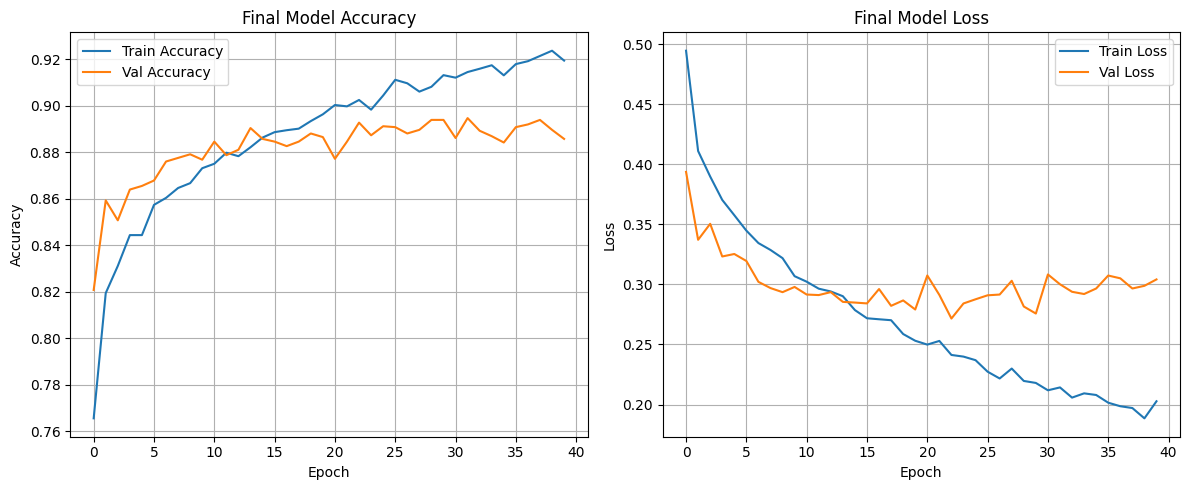


--- Script Finished ---


In [10]:
# ----- Plot Training History of Final Model -----

if history_final and hasattr(history_final, 'history') and history_final.history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if 'accuracy' in history_final.history: plt.plot(history_final.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history_final.history: plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
    plt.title('Final Model Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    if 'loss' in history_final.history: plt.plot(history_final.history['loss'], label='Train Loss')
    if 'val_loss' in history_final.history: plt.plot(history_final.history['val_loss'], label='Val Loss')
    plt.title('Final Model Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("Skipping plotting of training history as final model training was not completed or history is unavailable.")

print("\n--- Script Finished ---")

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, precision_recall_fscore_support

# ----- FUNCTION TO PLOT CONFUSION MATRIX -----
def plot_confusion_matrix_custom(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# ----- FUNCTION TO PLOT METRICS BARCHART  -----
def plot_metrics_barchart(metrics_data, class_names, title='Metrics per Class'):
    """
    Plots a grouped bar chart for precision, recall, f1-score, f2-score for each class.
    metrics_data should be a dictionary like:
    {
        'Precision': [precision_class0, precision_class1],
        'Recall': [recall_class0, recall_class1],
        'F1-score': [f1_class0, f1_class1],
        'F2-score': [f2_class0, f2_class1]
    }
    """
    df_metrics = pd.DataFrame(metrics_data, index=class_names)
    
    ax = df_metrics.plot(kind='bar', figsize=(10, 7), width=0.8, colormap='viridis') # You can change colormap
    plt.title(title, fontsize=15)
    plt.ylabel('Score (%)', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 1) # Scores are between 0 and 1, display as 0-100 if multiplied by 100 before
    
    # Add text annotations to the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%", # Format as percentage
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=10)
    
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()



--- Custom Validation Metrics Report ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.9050     0.8923     0.8986     0.8948       1346
fall          0.8835     0.8972     0.8903     0.8945       1226


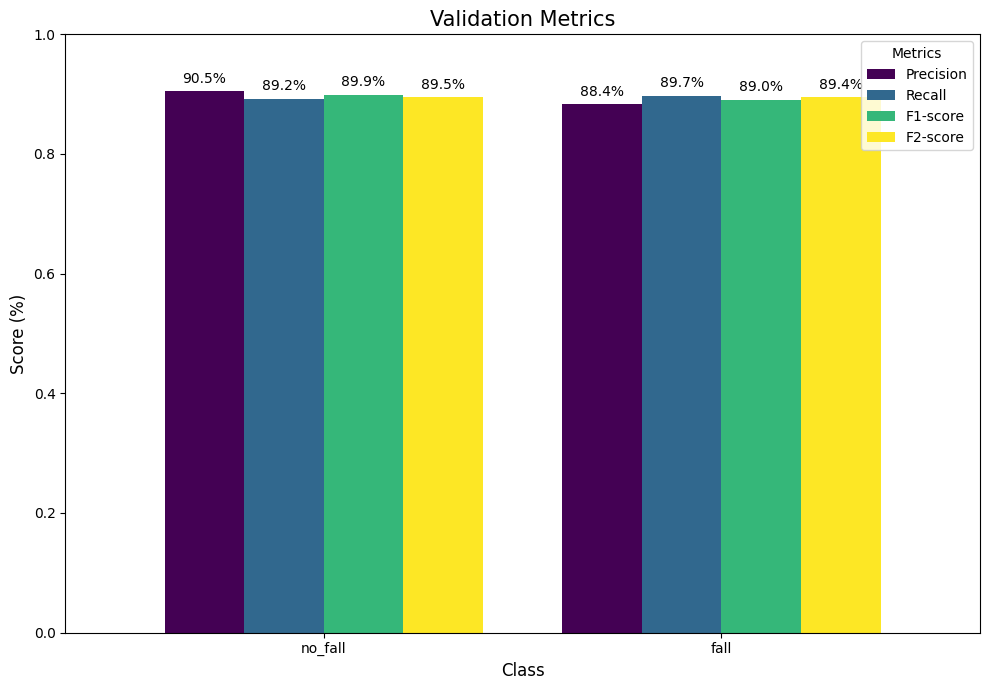

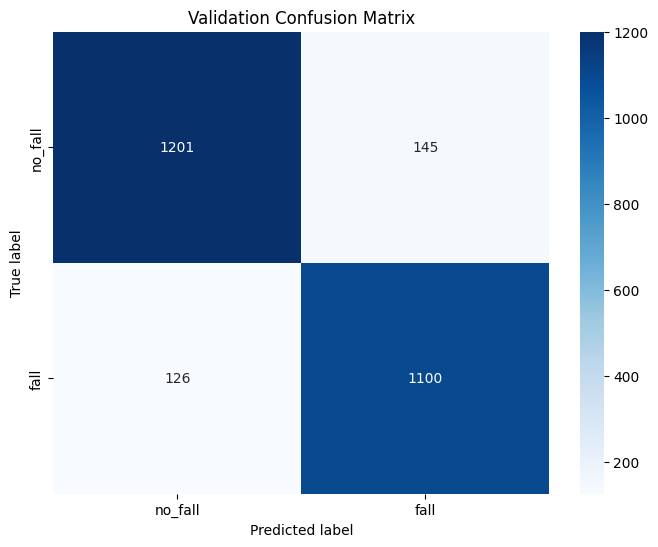



--- Custom Test Metrics Report ---
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
           Precision     Recall   F1-score   F2-score    Support
no_fall       0.8900     0.8960     0.8930     0.8948       1346
fall          0.8850     0.8785     0.8817     0.8798       1226


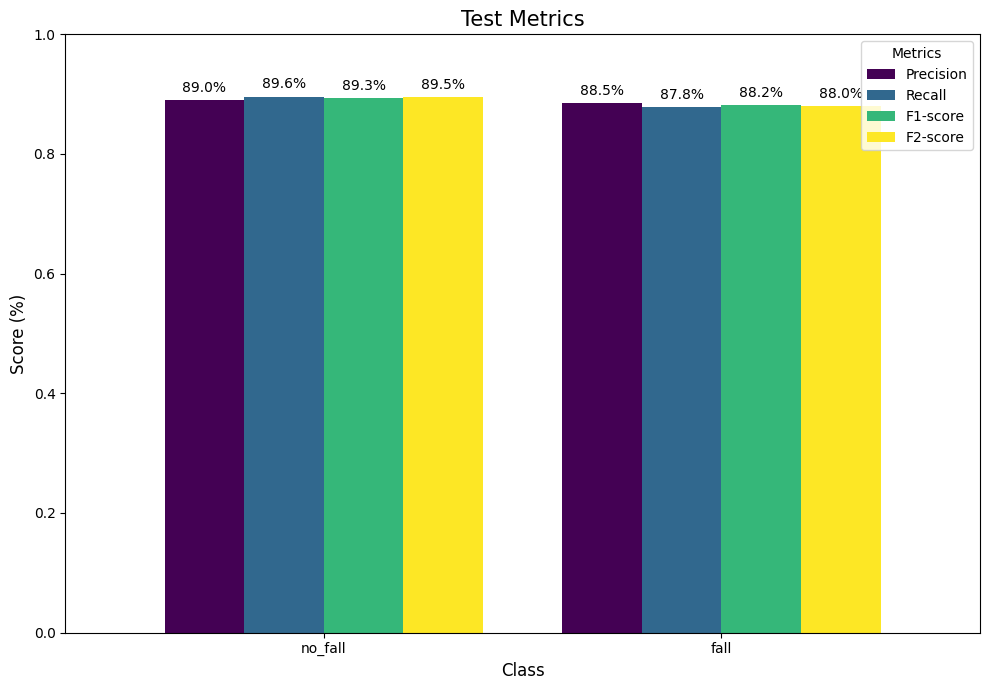

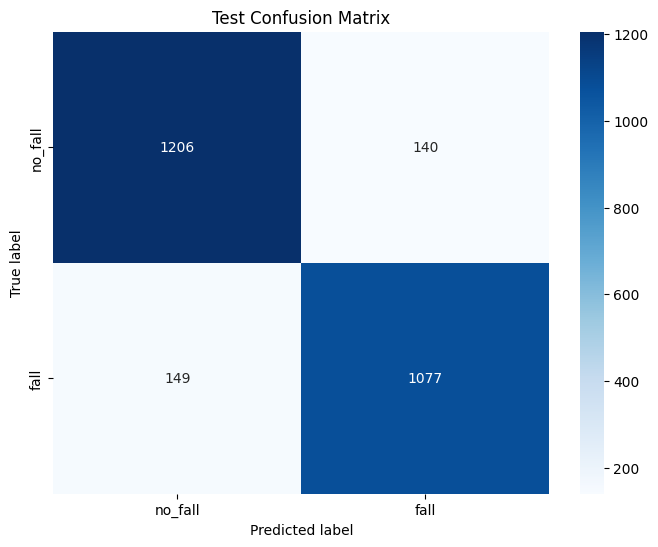

In [12]:
import pandas as pd

# ----- DETAILED EVALUATION AND REPORTING -----
target_names = ['no_fall', 'fall'] # สำหรับ classification report
class_labels = [0, 1] # Corresponding numerical labels

if final_model is not None: # ตรวจสอบว่า final_model ถูกสร้างและเทรนแล้ว
    # --- Evaluation on Validation Set ---
    if X_val_orig.size > 0 and y_val_orig.size > 0:
        print("\n\n--- Custom Validation Metrics Report ---")
        y_pred_val_probs = final_model.predict(X_val_orig)
        y_pred_val_classes = (y_pred_val_probs > 0.5).astype(int).flatten()

        # Calculate metrics per class
        precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
            y_val_orig, y_pred_val_classes, labels=class_labels, zero_division=0
        )
        f2_val_per_class = fbeta_score(y_val_orig, y_pred_val_classes, beta=2, labels=class_labels, average=None, zero_division=0)

        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_val[i]:>10.4f} {recall_val[i]:>10.4f} {f1_val[i]:>10.4f} {f2_val_per_class[i]:>10.4f} {support_val[i]:>10}")
        
        # For plotting (scores between 0 and 1)
        val_metrics_for_plot = {
            'Precision': precision_val,
            'Recall': recall_val,
            'F1-score': f1_val,
            'F2-score': f2_val_per_class
        }
        plot_metrics_barchart(val_metrics_for_plot, target_names, title='Validation Metrics')

        # Confusion Matrix
        cm_val = confusion_matrix(y_val_orig, y_pred_val_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_val, classes=target_names, title='Validation Confusion Matrix')
    else:
        print("\nValidation data is empty. Skipping detailed validation metrics report.")

    # --- Evaluation on Test Set ---
    if X_test_orig.size > 0 and y_test_orig.size > 0:
        print("\n\n--- Custom Test Metrics Report ---")
        y_pred_test_probs = final_model.predict(X_test_orig)
        y_pred_test_classes = (y_pred_test_probs > 0.5).astype(int).flatten()

        # Calculate metrics per class
        precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
            y_test_orig, y_pred_test_classes, labels=class_labels, zero_division=0
        )
        f2_test_per_class = fbeta_score(y_test_orig, y_pred_test_classes, beta=2, labels=class_labels, average=None, zero_division=0)

        print(f"{'':9} {'Precision':>10} {'Recall':>10} {'F1-score':>10} {'F2-score':>10} {'Support':>10}")
        for i, class_name in enumerate(target_names):
            print(f"{class_name:9} {precision_test[i]:>10.4f} {recall_test[i]:>10.4f} {f1_test[i]:>10.4f} {f2_test_per_class[i]:>10.4f} {support_test[i]:>10}")

        # For plotting
        test_metrics_for_plot = {
            'Precision': precision_test,
            'Recall': recall_test,
            'F1-score': f1_test,
            'F2-score': f2_test_per_class
        }
        plot_metrics_barchart(test_metrics_for_plot, target_names, title='Test Metrics')
        
        # Confusion Matrix
        cm_test = confusion_matrix(y_test_orig, y_pred_test_classes, labels=class_labels)
        plot_confusion_matrix_custom(cm_test, classes=target_names, title='Test Confusion Matrix')
    else:
        print("\nTest data is empty. Skipping detailed test metrics report.")
else:
    print("Final model was not trained (likely due to empty training data). Skipping detailed evaluation.")

In [13]:
import numpy as np
from pathlib import Path
import os 

# --- เริ่มการ Error Analysis และการบันทึก Log ---
print("\nStarting Error Analysis and Logging...")

# กำหนดชื่อไฟล์ Log
error_log_filename = "error_analysis_report.txt"

# ตรวจสอบว่าตัวแปรที่จำเป็นมีอยู่จริง
if ('y_val_orig' not in locals() or
    'y_pred_val_classes' not in locals() or
    'val_npy_filepaths' not in locals() or
    'y_pred_val_probs' not in locals() or
    'target_names' not in locals()):
    print("ERROR: One or more required variables (y_val_orig, y_pred_val_classes, val_npy_filepaths, y_pred_val_probs, target_names) are not defined.")
    print("Cannot perform error analysis.")
else:
    # เปิดไฟล์ log เพื่อเขียน
    with open(error_log_filename, "w", encoding="utf-8") as log_f:
        log_f.write("--- Error Analysis Report ---\n")
        log_f.write(f"Timestamp: {pd.Timestamp.now()}\n") # เพิ่ม pandas ถ้ายังไม่มี `import pandas as pd`

        # --- วิเคราะห์ Validation Set ---
        log_f.write("\n\n=== Validation Set Analysis ===\n")
        fp_indices_val = np.where((y_pred_val_classes == 1) & (y_val_orig == 0))[0]
        fn_indices_val = np.where((y_pred_val_classes == 0) & (y_val_orig == 1))[0]

        log_f.write(f"Total Validation Samples: {len(y_val_orig)}\n")
        log_f.write(f"False Positives (No_Fall predicted as Fall): {len(fp_indices_val)}\n")
        log_f.write(f"False Negatives (Fall predicted as No_Fall): {len(fn_indices_val)}\n")

        # บันทึกรายละเอียดของ False Positives (Validation) ทั้งหมด
        log_f.write("\n--- Details of False Positives (Validation) ---\n")
        if len(fp_indices_val) > 0:
            for i, fp_idx in enumerate(fp_indices_val):
                true_label = y_val_orig[fp_idx]
                pred_label = y_pred_val_classes[fp_idx]
                pred_prob_fall = y_pred_val_probs[fp_idx]
                if isinstance(pred_prob_fall, (np.ndarray, list)): pred_prob_fall = pred_prob_fall[0]
                
                npy_full_path_str = val_npy_filepaths[fp_idx]
                npy_filename = Path(npy_full_path_str).name
                original_video_name = "N/A" # Placeholder
                try: # Logic การ parse ชื่อวิดีโอ (ปรับตามรูปแบบชื่อไฟล์ของคุณ)
                    if "_keypoints" in npy_filename: original_video_name = npy_filename.split("_keypoints")[0]
                    elif "_fall_" in npy_filename: original_video_name = npy_filename.split("_fall_")[0]
                    elif "_nofall_" in npy_filename: original_video_name = npy_filename.split("_nofall_")[0]
                    else: original_video_name = npy_filename.split("_seq")[0] if "_seq" in npy_filename else Path(npy_filename).stem.rsplit('_', 1)[0] if '_' in Path(npy_filename).stem else Path(npy_filename).stem
                except: pass

                log_f.write(f"\nFP Sample #{i+1} (Original Index: {fp_idx})\n")
                log_f.write(f"  NPY File: {npy_filename}\n")
                log_f.write(f"  Derived Original Video: {original_video_name}\n")
                log_f.write(f"  True Label: {target_names[true_label]} ({true_label})\n")
                log_f.write(f"  Predicted Label: {target_names[pred_label]} ({pred_label})\n")
                log_f.write(f"  Predicted Probability (for Fall): {pred_prob_fall:.4f}\n")
                log_f.write(f"  NPY Full Path: {npy_full_path_str}\n") # เพิ่ม path เต็มเพื่อให้ track ง่าย
                log_f.write(f"  --- Manual Analysis Notes for this sample --- \n")
                log_f.write(f"  Observed Movement: \n")
                log_f.write(f"  Keypoint Quality: \n")
                log_f.write(f"  Hypothesis for Error: \n")
                log_f.write(f"  ---------------------------------------------\n")
        else:
            log_f.write("No False Positives found in Validation Set.\n")

        # บันทึกรายละเอียดของ False Negatives (Validation) ทั้งหมด
        log_f.write("\n--- Details of False Negatives (Validation) ---\n")
        if len(fn_indices_val) > 0:
            for i, fn_idx in enumerate(fn_indices_val):
                true_label = y_val_orig[fn_idx]
                pred_label = y_pred_val_classes[fn_idx]
                pred_prob_fall = y_pred_val_probs[fn_idx]
                if isinstance(pred_prob_fall, (np.ndarray, list)): pred_prob_fall = pred_prob_fall[0]

                npy_full_path_str = val_npy_filepaths[fn_idx]
                npy_filename = Path(npy_full_path_str).name
                original_video_name = "N/A"
                try: # Logic การ parse ชื่อวิดีโอ
                    if "_keypoints" in npy_filename: original_video_name = npy_filename.split("_keypoints")[0]
                    elif "_fall_" in npy_filename: original_video_name = npy_filename.split("_fall_")[0]
                    elif "_nofall_" in npy_filename: original_video_name = npy_filename.split("_nofall_")[0]
                    else: original_video_name = npy_filename.split("_seq")[0] if "_seq" in npy_filename else Path(npy_filename).stem.rsplit('_', 1)[0] if '_' in Path(npy_filename).stem else Path(npy_filename).stem
                except: pass
                
                log_f.write(f"\nFN Sample #{i+1} (Original Index: {fn_idx})\n")
                log_f.write(f"  NPY File: {npy_filename}\n")
                log_f.write(f"  Derived Original Video: {original_video_name}\n")
                log_f.write(f"  True Label: {target_names[true_label]} ({true_label})\n")
                log_f.write(f"  Predicted Label: {target_names[pred_label]} ({pred_label})\n")
                log_f.write(f"  Predicted Probability (for Fall): {pred_prob_fall:.4f}\n")
                log_f.write(f"  NPY Full Path: {npy_full_path_str}\n")
                log_f.write(f"  --- Manual Analysis Notes for this sample --- \n")
                log_f.write(f"  Observed Movement: \n")
                log_f.write(f"  Keypoint Quality: \n")
                log_f.write(f"  Hypothesis for Error: \n")
                log_f.write(f"  ---------------------------------------------\n")
        else:
            log_f.write("No False Negatives found in Validation Set.\n")

        # --- (Optional) ทำซ้ำสำหรับ Test Set ---
        if ('y_test_orig' in locals() and 'y_pred_test_classes' in locals() and 
            'test_npy_filepaths' in locals() and 'y_pred_test_probs' in locals()):
            log_f.write("\n\n=== Test Set Analysis ===\n")
            fp_indices_test = np.where((y_pred_test_classes == 1) & (y_test_orig == 0))[0]
            fn_indices_test = np.where((y_pred_test_classes == 0) & (y_test_orig == 1))[0]

            log_f.write(f"Total Test Samples: {len(y_test_orig)}\n")
            log_f.write(f"False Positives: {len(fp_indices_test)}\n")
            log_f.write(f"False Negatives: {len(fn_indices_test)}\n")
            
            # (ส่วน log FP และ FN ของ Test Set จะคล้ายกับ Validation Set, แค่เปลี่ยนตัวแปร _val เป็น _test)
            # ... (สามารถ copy & paste ส่วน log FP/FN ของ Validation แล้วแก้ตัวแปรได้) ...
            log_f.write("\n--- Details of False Positives (Test) ---\n")
            if len(fp_indices_test) > 0:
                for i, fp_idx_t in enumerate(fp_indices_test):
                    # ... ดึงข้อมูลและ log เหมือน FP Validation ...
                    true_label_t = y_test_orig[fp_idx_t]
                    # ... (ที่เหลือเหมือนกัน)
                    log_f.write(f"\nFP_Test Sample #{i+1} (Original Index: {fp_idx_t}) ... (details) ...\n")
            else: log_f.write("No False Positives found in Test Set.\n")

            log_f.write("\n--- Details of False Negatives (Test) ---\n")
            if len(fn_indices_test) > 0:
                for i, fn_idx_t in enumerate(fn_indices_test):
                    # ... ดึงข้อมูลและ log เหมือน FN Validation ...
                    log_f.write(f"\nFN_Test Sample #{i+1} (Original Index: {fn_idx_t}) ... (details) ...\n")
            else: log_f.write("No False Negatives found in Test Set.\n")

        else:
            log_f.write("\n\nTest data for error analysis not fully available. Skipping detailed Test Set analysis in log.\n")

    print(f"\nError Analysis Report saved to: {error_log_filename}")


Starting Error Analysis and Logging...

Error Analysis Report saved to: error_analysis_report.txt
